# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
import cv2
import glob
import itertools
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import tensorflow as tf
import os


In [14]:
checkpoint_var = {}
checkpoint_file = 'data/checkpoint'
checkpoint_force = False
    



---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle


# TODO: Fill this in based on where you saved the training and testing data

training_file = 'data/train.p'
validation_file= 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(y_train)

# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: Number of testing examples.
n_valid = len(y_valid)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_valid)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

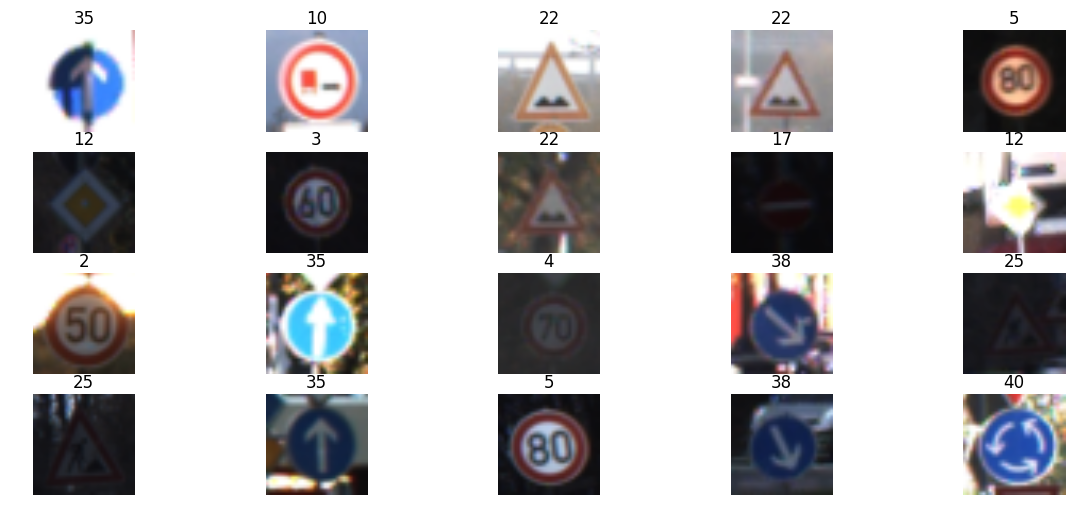

In [4]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
random.seed(1525)
# show image of 10 random data points
fig, axs = plt.subplots(4,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(20):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])
    
#len(set( y_train))


Upon looking at these 20 random images, it struck me that brightness is something to carefully consider. I'm also suprised by the poor quality of the images, pleasantly surpised as it means a well performing model will perform well in real world scenarios.

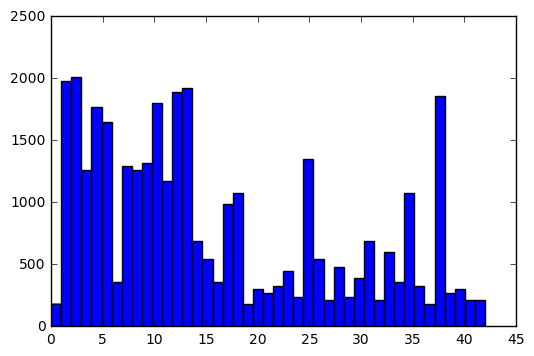

In [5]:
plt.hist(y_train,bins=43);

The classes are heavily imbalanced. My first instinct is to find a method to correct for the imbalance. However, I agree with Prof. Vivek Yadav and will rather keep the imbalance but increase the overall number of images by using augmentations.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

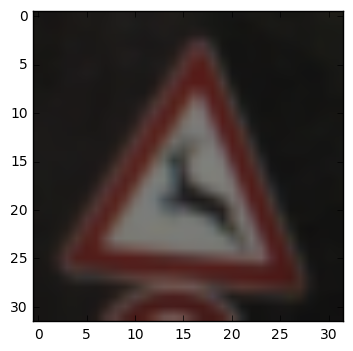

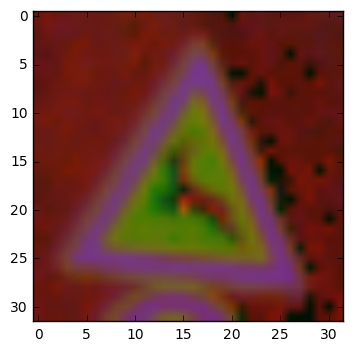

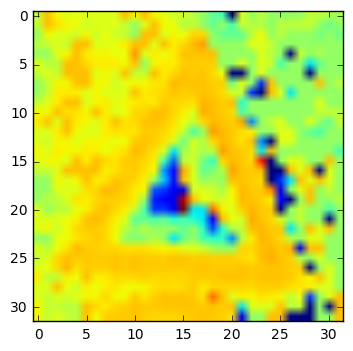

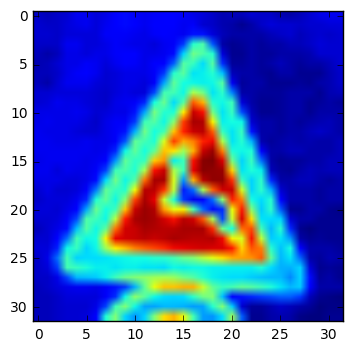

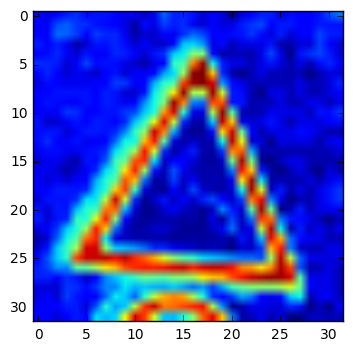

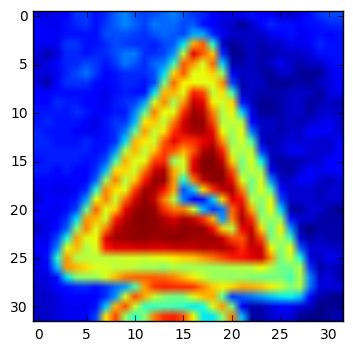

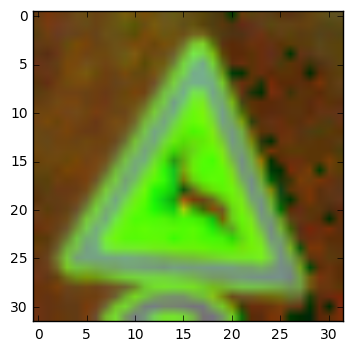

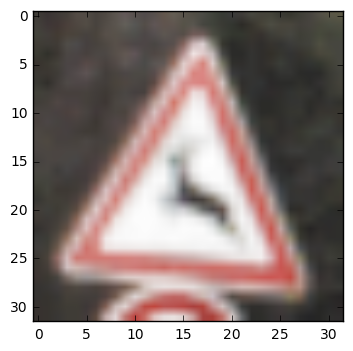

In [6]:
# Testing the CLAHE (Contrast Limited Adaptive Histogram Equalization)

#-----Reading the image-----------------------------------------------------
img = X_train[800]
plt.figure()
plt.imshow(img) 

#-----Converting image to HLS Color model----------------------------------- 
lab= cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
plt.figure()
plt.imshow(lab)

#-----Splitting the HLS image to different channels-------------------------
h, l, s = cv2.split(lab)
plt.figure()
plt.imshow( h)
plt.figure()
plt.imshow( l)
plt.figure()
plt.imshow( s)

#-----Applying CLAHE to L-channel-------------------------------------------
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(3,3))
cl = clahe.apply(l)
plt.figure()
plt.imshow(cl)

#-----Merge the CLAHE enhanced L-channel with the h and s channel-----------
limg = cv2.merge((h,cl,s))
plt.figure()
plt.imshow(limg)

#-----Converting image from LAB Color model to RGB model--------------------
final = cv2.cvtColor(limg, cv2.COLOR_HLS2BGR)
plt.figure()
plt.imshow( final)

#_____END_____#

In [7]:
# Implement the CLAHE function

def CLAHE_trans(pre_img):

    #-----Converting image to HLS Color model----------------------------------- 
    pre_lab= cv2.cvtColor(pre_img, cv2.COLOR_BGR2HLS)

    #-----Splitting the HLS image to different channels-------------------------
    h, l, s = cv2.split(pre_lab)

    #-----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(3,3))
    cl = clahe.apply(l)

    #-----Merge the CLAHE enhanced L-channel with the h and s channel-----------
    limg = cv2.merge((h,cl,s))

    #-----Converting image from LAB Color model to RGB model--------------------
    final = cv2.cvtColor(limg, cv2.COLOR_HLS2BGR)
    return final


In [8]:

for i in range(1,len(X_test)):
    X_test[i] = CLAHE_trans(X_test[i])
    
for i in range(1,len(X_train)):
    X_train[i] = CLAHE_trans(X_train[i])

    

In [9]:
## Normalize the train and test datasets to (-1,1)
## Got stuck  because of dtype issues, dtype: Unsigned integer (0 to 255)
## Going to scale to (0,1)

###v2.0 AS per lessons, I'm going to do MinMax Scaling (0.1,0.9)

X_train = X_train/255 * 0.8 + 0.1
X_test = X_test/255* 0.8 + 0.1

print(np.mean(X_train))
print(np.mean(X_test))

0.561057979566
0.560472210902


In [10]:

# One hot encode labels
def encode_labels(labels):
    labels = (np.arange(n_classes) == labels[:,None]).astype(np.float)
    return labels

In [11]:

y_train_oneh = encode_labels(y_train)
y_test_oneh = encode_labels(y_test)


In [12]:
# Function to generate transformed images
# from https://nbviewer.jupyter.org/github/vxy10/SCND_notebooks/blob/master/preprocessing_stuff/img_transform_NB.ipynb

def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

print('Success: transform_image function loaded.')



Success: transform_image function loaded.


In [13]:
##### Set to markdown to ignore

values, counts = np.unique(y_train, return_counts=True)
max_counts = counts.max()

if not os.path.isfile(checkpoint1_file) or checkpoint1_force:
    for class_ in values:
        print('working on class #', class_, '...')
        num_img_needed = max_counts-counts[class_]
        print(num_img_needed)

        first_example_index = next(index for index, val in enumerate(y_train) if val==class_)
        first_example = X_train[first_example_index]

        class_ = class_.reshape([1])

        for num in range(0,num_img_needed):
            transformed_example = transform_image(first_example,20,10,5)
            transformed_example = transformed_example.reshape([1, 32, 32, 3])
            X_train = np.concatenate([X_train, transformed_example])
            y_train = np.concatenate([y_train, class_])
            #print(num)
            
            checkpoint_var['X_train'] = X_train
            checkpoint_var['y_train'] = y_train
            checkpoint_var['X_test'] = X_test
            checkpoint_var['y_test'] = y_test
else 
     print('Checkpoint Already Exists. Data would be loaded from checkpoint. Set checkpoint_force to force new file.')

working on class # 0 ...
1830
working on class # 1 ...
30
working on class # 2 ...
0
working on class # 3 ...
750
working on class # 4 ...
240
working on class # 5 ...
360
working on class # 6 ...
1650
working on class # 7 ...
720
working on class # 8 ...
750
working on class # 9 ...
690
working on class # 10 ...
210
working on class # 11 ...
840
working on class # 12 ...
120
working on class # 13 ...
90
working on class # 14 ...
1320
working on class # 15 ...
1470
working on class # 16 ...
1650
working on class # 17 ...
1020
working on class # 18 ...
930
working on class # 19 ...
1830
working on class # 20 ...
1710
working on class # 21 ...
1740
working on class # 22 ...
1680
working on class # 23 ...
1560
working on class # 24 ...
1770
working on class # 25 ...
660
working on class # 26 ...
1470
working on class # 27 ...
1800
working on class # 28 ...
1530
working on class # 29 ...
1770
working on class # 30 ...
1620
working on class # 31 ...
1320
working on class # 32 ...
1800
worki

NameError: name 'plot_examples_per_class' is not defined

In [16]:

import pickle

if not os.path.isfile(checkpoint_file) or checkpoint_force:
    print('Caching variables in pickle file...')
    try:
        with open(checkpoint_file, 'wb') as pfile:
            pickle.dump(checkpoint_var, pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', checkpoint_file, ':', e)
        raise
    print('Data cached in pickle file.')
else:
    print('Pickle file already created. Set checkpoint1_force to force new file.')

Caching variables in pickle file...
Data cached in pickle file.


In [ ]:
import pickle 
checkpoint_file = 'data/checkpoint'

with open(checkpoint_file, 'rb') as pfile:
    pickle_data = pickle.load(pfile)
    for key in pickle_data:
        exec(key + "= pickle_data['" + str(key) + "']")
    del pickle_data  

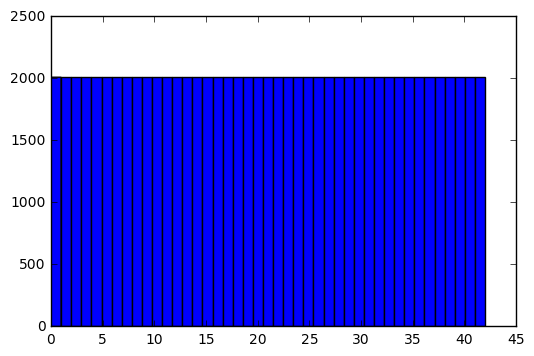

In [17]:
plt.hist(y_train,bins=43);

In [103]:
# Shuffle the data

from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

y_train_oneh = encode_labels(y_train)
y_test_oneh = encode_labels(y_test)

### Model Architecture

In [167]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Define your architecture here.
### Feel free to use as many code cells as needed.

# The below is only necessary to reset if the notebook has not been shutdown
tf.reset_default_graph()

EPOCHS = 10
BATCH_SIZE = 75

from tensorflow.contrib.layers import flatten

def neural_network(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.05
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    # Weight and bias
    # If not using grayscale, the third number in shape would be 3
    c1_weight = tf.Variable(tf.truncated_normal(shape = (5, 5, 3, 6), mean = mu, stddev = sigma))
    c1_bias = tf.Variable(tf.zeros(18))
    # Apply convolution
    conv_layer1 = tf.nn.conv2d(x, c1_weight, strides=[1, 1, 1, 1], padding='VALID') + c1_bias
    
    # Activation for layer 1
    conv_layer1 = tf.nn.relu(conv_layer1)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv_layer1 = tf.nn.avg_pool(conv_layer1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    # Note: The second layer is implemented the exact same as layer one, with layer 1 as input instead of x
    # And then of course changing the numbers to fit the desired ouput of 10x10x16
    # Weight and bias
    c2_weight = tf.Variable(tf.truncated_normal(shape = (5, 5, 18, 16), mean = mu, stddev = sigma))
    c2_bias = tf.Variable(tf.zeros(16))
    # Apply convolution for layer 2
    conv_layer2 = tf.nn.conv2d(conv_layer1, c2_weight, strides=[1, 1, 1, 1], padding='VALID') + c2_bias
    
    # Activation for layer 2
    conv_layer2 = tf.nn.relu(conv_layer2)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv_layer2 = tf.nn.avg_pool(conv_layer2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten to get to fully connected layers. Input = 5x5x16. Output = 400.
    flat = tf.contrib.layers.flatten(conv_layer2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    # Although this is fully connected, the weights and biases still are implemented similarly
    # There is no filter this time, so shape only takes input and output
    # Weight and bias
    fc1_weight = tf.Variable(tf.truncated_normal(shape = (400, 200), mean = mu, stddev = sigma))
    fc1_bias = tf.Variable(tf.zeros(200))
    # Here is the main change versus a convolutional layer - matrix multiplication instead of 2D convolution
    fc1 = tf.matmul(flat, fc1_weight) + fc1_bias
    
    # Activation for the first fully connected layer.
    # Same thing as before
    fc1 = tf.nn.relu(fc1)
    
    # Dropout, to prevent overfitting
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    # Same as the fc1 layer, just with updated output numbers
    fc2_weight = tf.Variable(tf.truncated_normal(shape = (200, 100), mean = mu, stddev = sigma))
    fc2_bias = tf.Variable(tf.zeros(100))
    # Again, matrix multiplication
    fc2 = tf.matmul(fc1, fc2_weight) + fc2_bias
    
    # Activation.
    fc2 = tf.nn.relu(fc2)
    
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # Layer 5 Fully Connected. Input = 84. Output = 43.
    # Since this is the final layer, output needs to match up with the number of classes
    fc3_weight = tf.Variable(tf.truncated_normal(shape = (100, 43), mean = mu, stddev = sigma))
    fc3_bias = tf.Variable(tf.zeros(43))
    # Again, matrix multiplication
    logits = tf.matmul(fc2, fc3_weight) + fc3_bias
    
    return logits


# Set placeholder variables for x, y, and the keep_prob for dropout
# Also, one-hot encode y
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)


# Setting learning rate, loss functions, and optimizer
rate = 1e-3

           

logits = neural_network(x)
cost = tf.reduce_mean(cross_entropy)+1e-5*regularizers
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)+1e-5*regularizers
optimizer = tf.train.AdamOptimizer(learning_rate = rate).minimize(cost)
training_operation = optimizer.minimize(loss_operation)

# The below is used in the validation part of the neural network
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy =  sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


ValueError: Dimensions must be equal, but are 6 and 18 for 'add' (op: 'Add') with input shapes: [?,28,28,6], [18].

In [137]:
img_size = 32
num_channels = 3

features = tf.placeholder(tf.float32, shape=[None, img_size, img_size,num_channels],
                   name='features')
labels_true = tf.placeholder(tf.float32,shape=[None,n_classes], name='y_true')

labels_true_cls = tf.argmax(labels_true, dimension=1)

In [139]:
def random_batch():
    # Number of images in the training-set.
    num_images = len(X_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    features_batch = X_train[idx, :,:,:]
    labels_batch = y_train_oneh[idx, :]

    return features_batch, labels_batch

In [140]:
print(len(X_train))

86430


In [141]:
def get_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def get_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

def conv_layer(input,
               num_inp_channels,
               filter_size,
               num_filters,
              use_pooling):
    shape = [filter_size, filter_size, num_inp_channels,num_filters]
    weights = get_weights(shape)
    biases = get_biases(num_filters)
    layer = tf.nn.conv2d(input = input,
                        filter = weights,
                        strides = [1,1,1,1],
                        padding = 'SAME')

    layer += biases

    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                         ksize=[1, 2, 2, 1],
                         strides=[1, 2, 2, 1],
                         padding='SAME')
    layer = tf.nn.relu(layer)

    return layer, weights
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

def fc_layer(input,          # The previous layer.
             num_inputs,     # Num. inputs from prev. layer.
             num_outputs,    # Num. outputs.
             use_relu=True): # Use Rectified Linear Unit (ReLU)?
    weights = get_weights(shape=[num_inputs, num_outputs])
    biases = get_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer,weights

def dropout_layer(layer, keep_prob):
    layer_drop = tf.nn.dropout(layer, keep_prob)
    return layer_drop

In [142]:
## Convlayer 0
filter_size0 = 1
num_filters0 = 3

## Convlayer 1
filter_size1 = 5
num_filters1 = 32

## Convlayer 2
filter_size2 = 5
num_filters2 = 64

## Convlayer 3
filter_size3 = 5
num_filters3 = 128


## FC_size 1
fc_size1 = 1024
## FC_size 2
fc_size2 = 1024

## FC_size 2
fc_size1 = 1024
## FC_size 2
fc_size2 = 1024

## Dropout
drop_prob = 0.5

keep_prob = tf.placeholder(tf.float32)

In [143]:
layer_conv0, weights_conv0 = \
        conv_layer(input=features,
                   num_inp_channels=num_channels,
                   filter_size=filter_size0,
                   num_filters=num_filters0,
                   use_pooling=True)

layer_conv1, weights_conv1 = \
        conv_layer(input=layer_conv0,
                   num_inp_channels=num_filters0,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

layer_conv1_drop = dropout_layer(layer_conv1, keep_prob)
    
layer_conv2, weights_conv2 = \
        conv_layer(input=layer_conv1,
                   num_inp_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
    
layer_conv3, weights_conv3 = \
        conv_layer(input=layer_conv2,
                   num_inp_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True)
    
layer_conv3_drop = dropout_layer(layer_conv3, keep_prob)


layer_flat, num_fc_layers = flatten_layer(layer_conv3_drop)


fc_layer1,weights_fc1 = fc_layer(layer_flat,          # The previous layer.
             num_fc_layers,     # Num. inputs from prev. layer.
             fc_size1,    # Num. outputs.
             use_relu=True)
fc_layer1_drop = dropout_layer(fc_layer1, keep_prob)


fc_layer2,weights_fc2 = fc_layer(fc_layer1_drop,          # The previous layer.
             fc_size1,     # Num. inputs from prev. layer.
             n_classes,    # Num. outputs.
             use_relu=False)

labels_pred = tf.nn.softmax(fc_layer2)
labels_pred_cls = tf.argmax(labels_pred, dimension=1)

regularizers = (tf.nn.l2_loss(weights_conv0)
                + tf.nn.l2_loss(weights_conv1) + tf.nn.l2_loss(weights_conv2)
                + tf.nn.l2_loss(weights_conv3) 
                + tf.nn.l2_loss(weights_fc1)  + tf.nn.l2_loss(weights_fc2) )

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc_layer2,
                                                        labels=labels_true)
cost = tf.reduce_mean(cross_entropy)+1e-5*regularizers
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
correct_prediction = tf.equal(labels_pred_cls, labels_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [158]:
def optimize(num_iterations):
    global total_iterations
    global best_validation_accuracy
    global last_improvement
    global best_test_accuracy

    global val_acc_list
    global batch_acc_list
    global test_acc_list

    #num_iter = np.math.floor(len(labels_train_rot)/batch_size)
    #num_iter = min(num_iter-2,num_iterations)
    num_iter = num_iterations
    for i in range(num_iter):
        total_iterations+=1
        # Get batch for training
        features_batch, labels_true_batch = random_batch()
        #print(features_batch.shape)
        #idx = np.arange(batch_size*i,batch_size*(i+1))
        #features_batch = Image_GS_train_rot[idx, :,:,:]
        #labels_true_batch = labels_train_rot[idx, :]f
        feed_dict_batch = {features:features_batch,
                            labels_true: labels_true_batch,
                            keep_prob: 0.5}
        session.run(optimizer,feed_dict = feed_dict_batch)

        if ((total_iterations % 200 == 0) or (i == (num_iter - 1))):
            # Calculate the accuracy on the training-set.
            acc_batch = session.run(accuracy, feed_dict=feed_dict_batch)
            acc_valid = session.run(accuracy,feed_dict=feed_dict_valid)
            val_acc_list.append(acc_valid)
            batch_acc_list.append(acc_batch)
            if acc_valid > best_validation_accuracy:
                best_validation_accuracy = acc_valid
                last_improvement = total_iterations
                improved_str = '*'
                saver = tf.train.Saver()
                saver.save(sess=session, save_path='c:/work/repos/CarND-LeNet-Lab/model_best_batch')
            else:
                improved_str = ''

            if total_iterations - last_improvement > require_improvement:
                print("No improvement found in a while, stopping optimization.")
                break

            # Message for printing.
            if ((total_iterations % 5000 == 0) or (i == (num_iter - 1))):
                msg = "# {0:>6}, Train Acc.: {1:>6.1%}, Val Acc.: {2:>6.1%}, Test Acc.: {3:>6.1%}"
                acc_test = session.run(accuracy,feed_dict=feed_dict_test)

                if best_test_accuracy<acc_test:
                    saver = tf.train.Saver()
                    saver.save(sess=session, save_path='c:/work/repos/CarND-LeNet-Lab/model_best_test')
                    best_test_accuracy = acc_test
                    #print_accuracy()
                # Print it.
                print(msg.format(i+1, acc_batch,acc_valid,
                                     acc_test))

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [145]:
batch_size = 100

In [162]:


feed_dict_valid = {features: X_test,
                 labels_true: y_test_oneh,
                 labels_true_cls:y_test,
                 keep_prob:1.0}

feed_dict_test = {features: X_test,
                 labels_true: y_test_oneh,
                 labels_true_cls:y_test,
                 keep_prob:1.0}

In [163]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [166]:
total_iterations = 0
val_acc_list = []
batch_acc_list = []
train_acc_list = []

best_validation_accuracy = 0.0
last_improvement = 0
best_test_accuracy = 0.0


require_improvement = 10000
    
optimize(1000)

(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 

In [ ]:
session.run(optimizer,feed_dict = feed_dict_batch)

In [ ]:
start_time = time.time()
total_iterations = 0
require_improvement = 10000
ang_rot = 10
trans_rot = 2
shear_rot = 2
n_opt = 40000
best_test_accuracy = 0.0

for i_train in range(1):
    best_validation_accuracy = 0.0
    last_improvement = 0

    #Image_train_GS_rot,y_train_rot,labels_train_rot = gen_transformed_data(X_train,y_train,43,5000,30,5,5,1)


    if i_train>-1:
        ang_rot = 10*0.9**(i_train)
        trans_rot = 2*0.9**(i_train)
        shear_rot = 2*0.9**(i_train)
        require_improvement = 5000
        n_opt = 10000




    X_train_SS, X_valid_SS, y_train_SS , y_valid_SS = \
                                train_test_split(X_train,
                                                 y_train,
                                                 test_size=0.1,
                                                 random_state=22)
    labels_valid_SS = OHE_labels(y_valid_SS,43)
    image_GS_valid = np.array([pre_process_image(X_valid_SS[i]) for i in range(len(X_valid_SS))],
                          dtype = np.float32)
    #image_GS_valid = np.reshape(image_GS_valid,(-1,32,32,1))

    feed_dict_valid = {features: image_GS_valid,
                 labels_true: labels_valid_SS,
                 labels_true_cls:y_valid_SS,
                 keep_prob:1.0}

    Image_train_GS_rot,y_train_rot,labels_train_rot = gen_extra_data(X_train_SS,y_train_SS,43,5,
                                                                     ang_rot,trans_rot,shear_rot,1)
    print('Optimization Loop # '+str(i_train))    
    Image_train_GS_rot_1 = Image_train_GS_rot
    #np.reshape(Image_train_GS_rot,(-1,32,32,1))
    #
    optimize(n_opt)
    #print_accuracy()


end_time = time.time()

time_diff = end_time-start_time

In [46]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.


save_file = 'c:/work/repos/CarND-LeNet-Lab/train_model.ckpt'
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            loss = sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 0.7})
            
        validation_accuracy = evaluate(X_test, y_test)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    # Save the model
    saver.save(sess, save_file)
    print('Trained Model Saved.')

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Training...

EPOCH 1 ...
Validation Accuracy = 0.623

EPOCH 2 ...
Validation Accuracy = 0.739

EPOCH 3 ...
Validation Accuracy = 0.794

EPOCH 4 ...
Validation Accuracy = 0.830

EPOCH 5 ...
Validation Accuracy = 0.852

EPOCH 6 ...
Validation Accuracy = 0.872

EPOCH 7 ...
Validation Accuracy = 0.872

EPOCH 8 ...
Validation Accuracy = 0.884

EPOCH 9 ...
Validation Accuracy = 0.889

EPOCH 10 ...
Validation Accuracy = 0.887

Trained Model Saved.


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 